In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [20]:
df = pd.read_csv("/content/drive/MyDrive/DSC4900 /diabetic_data.csv")

In [21]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


**Preprocessing**

In [22]:
# Replacing '?' with NaN, dropping ID and columns with too many values
df.replace('?', np.nan, inplace=True)

df.drop(columns=[
    'encounter_id', 'patient_nbr',
    'weight', 'payer_code', 'medical_specialty'
], inplace=True)

df.dropna(subset=['race', 'diag_1', 'diag_2', 'diag_3'], inplace=True)

for col in df.columns:
    if df[col].isna().sum() > 0:
        if df[col].dtype == 'object':
            df[col].fillna("Unknown", inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

# Creating binary target
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x in ['<30', '>30'] else 0)

# Checking shape and readmitted distribution
print("Shape after cleaning:", df.shape)
print("Readmitted distribution:\n", df['readmitted_binary'].value_counts(normalize=True))

Shape after cleaning: (98053, 46)
Readmitted distribution:
 readmitted_binary
0    0.533773
1    0.466227
Name: proportion, dtype: float64


<ipython-input-22-abe45f3be940>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("Unknown", inplace=True)


In [23]:
# Encoding categorical columns
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

X = df_encoded.drop(['readmitted', 'readmitted_binary'], axis=1)
y = df_encoded['readmitted_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))

Train size: (78442, 44)
Test size: (19611, 44)
Train target distribution:
 readmitted_binary
0    0.53377
1    0.46623
Name: proportion, dtype: float64


**Logistic Regression**

Confusion Matrix:
 [[8298 2170]
 [5428 3715]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.79      0.69     10468
           1       0.63      0.41      0.49      9143

    accuracy                           0.61     19611
   macro avg       0.62      0.60      0.59     19611
weighted avg       0.62      0.61      0.60     19611

ROC AUC Score: 0.6518737897419054


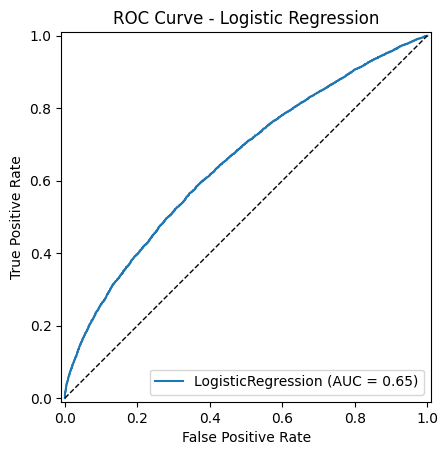

In [24]:
# Building logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# ROC Curve
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
# Logistic regression AUC is 0.65. Moderate prediction, better than random guessing.

**Random Forest**

Confusion Matrix:
 [[7599 2869]
 [4368 4775]]

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.73      0.68     10468
           1       0.62      0.52      0.57      9143

    accuracy                           0.63     19611
   macro avg       0.63      0.62      0.62     19611
weighted avg       0.63      0.63      0.63     19611

ROC AUC Score: 0.6821516037522268


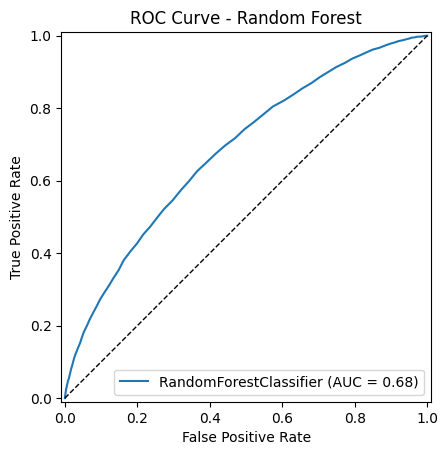

In [25]:
# Building random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_rf))

# ROC Curve
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [26]:
# Checking for overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

train_probs_rf = rf.predict_proba(X_train)[:, 1]
test_probs_rf = rf.predict_proba(X_test)[:, 1]

# AUC scores
train_auc_rf = roc_auc_score(y_train, train_probs_rf)
test_auc_rf = roc_auc_score(y_test, test_probs_rf)

print(f"Random Forest - Training AUC: {train_auc_rf:.3f}")
print(f"Random Forest - Testing AUC:  {test_auc_rf:.3f}")

Random Forest - Training AUC: 1.000
Random Forest - Testing AUC:  0.678


In [ ]:
# RF model is overfit as shown by the big difference between AUC scores, so tuning is needed.

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Random Forest AUC: 0.6844555741065395


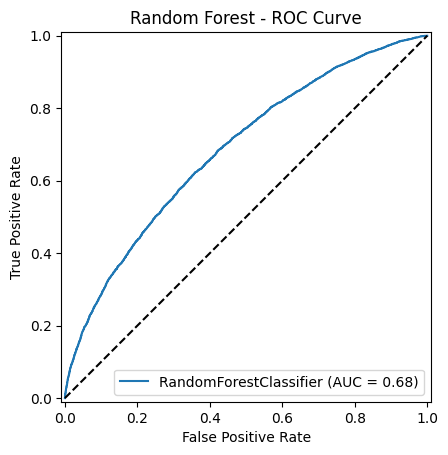

In [27]:
# Tuning using GridSearch
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, rf_params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

grid_rf.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score, RocCurveDisplay

best_rf = grid_rf.best_estimator_
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
print("Best Random Forest AUC:", roc_auc_score(y_test, y_prob_rf))

# ROC
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Random Forest - ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [13]:
# Checking for overfitting in tuned model
train_auc = roc_auc_score(y_train, best_rf.predict_proba(X_train)[:, 1])

test_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print("Training AUC:", round(train_auc, 4))
print("Test AUC", round(test_auc, 4))

Training AUC: 0.731
Test AUC 0.6845


In [ ]:
# Tuned RF model is not overfit and performed better than logistic regression with a higher AUC of 0.68.

**Gradient Boosting**

Confusion Matrix:
 [[7835 2597]
 [4599 4580]]

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.75      0.69     10432
           1       0.64      0.50      0.56      9179

    accuracy                           0.63     19611
   macro avg       0.63      0.63      0.62     19611
weighted avg       0.63      0.63      0.63     19611

ROC AUC Score: 0.6901585361391065


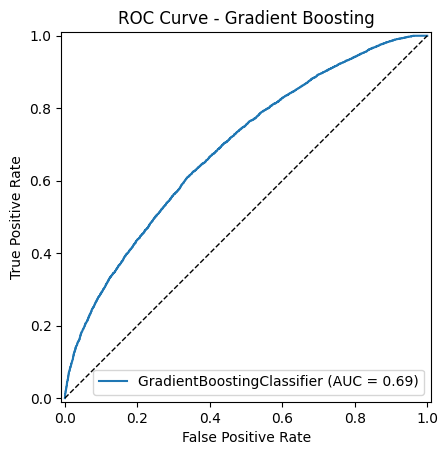

In [28]:
# Building Gradient Boosting model
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_gb))

# ROC Curve
RocCurveDisplay.from_estimator(gb, X_test, y_test)
plt.title("ROC Curve - Gradient Boosting")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [15]:
# Checking for overfitting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

train_probs_gb = gb.predict_proba(X_train)[:, 1]
test_probs_gb = gb.predict_proba(X_test)[:, 1]

train_auc_gb = roc_auc_score(y_train, train_probs_gb)
test_auc_gb = roc_auc_score(y_test, test_probs_gb)

print(f"Gradient Boosting - Training AUC: {train_auc_gb:.3f}")
print(f"Gradient Boosting - Testing AUC:  {test_auc_gb:.3f}")

Gradient Boosting - Training AUC: 0.700
Gradient Boosting - Testing AUC:  0.690


In [ ]:
# Model is not overfit.

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Gradient Boosting AUC: 0.6996300195431423


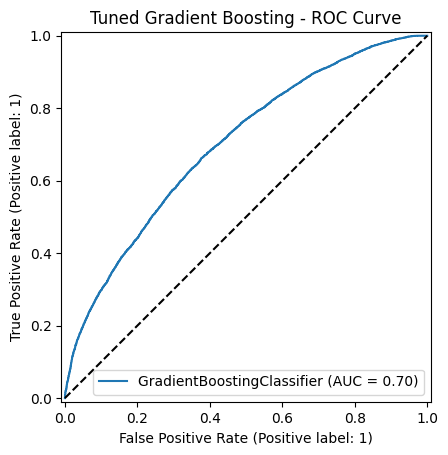

In [17]:
# Tuning using Gridsearch to improve AUC score
gb_params = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

gb = GradientBoostingClassifier(random_state=42)
grid_gb = GridSearchCV(gb, gb_params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

grid_gb.fit(X_train, y_train)

best_gb = grid_gb.best_estimator_
y_prob_gb = best_gb.predict_proba(X_test)[:, 1]
print("Best Gradient Boosting AUC:", roc_auc_score(y_test, y_prob_gb))

# ROC Curve
RocCurveDisplay.from_estimator(best_gb, X_test, y_test)
plt.title("Gradient Boosting - ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
# Gradient Boosting is the best performing model with the highest AUC of 0.70.

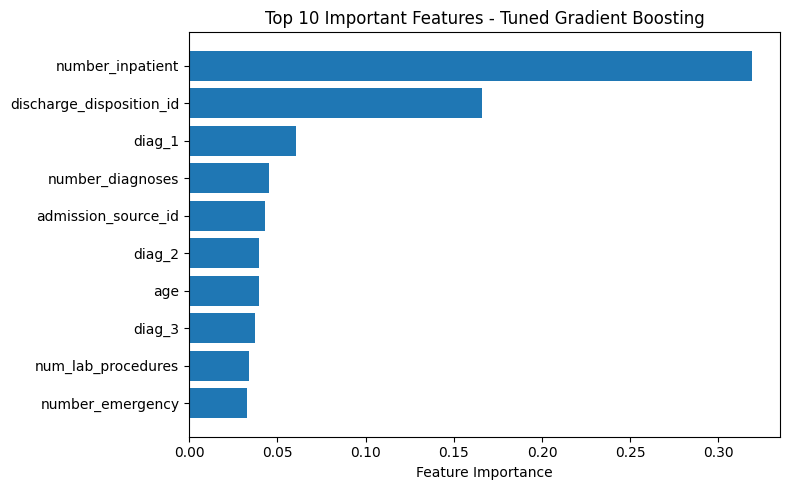

In [18]:
# Creating a feature importance chart from GB model
importances = best_gb.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()